In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from mxnet import nd, autograd, gluon
import mxnet as mx
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import datetime
from datetime import datetime

In [3]:
def padding(chars, maxlen):
    if len(chars) < maxlen:
        return chars + ' ' * (maxlen - len(chars))
    else:
        return chars[:maxlen]

def gen_date():
    rnd = int(np.random.uniform(low = 1000000000, high = 1350000000))
    timestamp = datetime.fromtimestamp(rnd)
    return str(timestamp.strftime('%Y-%B-%d %a')) # '%Y-%B-%d %H:%M:%S'

def format_date(x):
    return str(datetime.strptime(x, '%Y-%B-%d %a').strftime('%m/%d/%Y, %A')).lower() #'%H%M%S:%Y%m%d'

N = 1000
N_train = int(N * .9)
N_validation = N - N_train

in_seq_len = 32
out_seq_len = 32

added = set()
questions = []
answers = []
answers_y = []

while len(questions) < N:
    if len(questions) % 1000 == 0:
        print('i = {}'.format(len(questions)))
    a = gen_date()
    if a in added:
        continue
    question = '[{}]'.format(a)
    answer = '[' + str(format_date(a)) + ']'
    answer = padding(answer, out_seq_len)
    answer_y = str(format_date(a)) + ']'
    answer_y = padding(answer_y, out_seq_len)
    
    added.add(a)
    questions.append(question)
    answers.append(answer)
    answers_y.append(answer_y)

chars = list(set(''.join(questions[:20000])))
chars.extend(['[', ']']) # Start and End of Expression
chars.extend(list(set(''.join(answers[:20000]))))
chars = np.sort(list(set(chars)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

i = 0


In [4]:
print(questions[:10])
print(answers[:10])

['[2005-April-24 Sun]', '[2007-April-20 Fri]', '[2002-September-11 Wed]', '[2002-December-31 Tue]', '[2011-January-17 Mon]', '[2003-September-29 Mon]', '[2007-September-10 Mon]', '[2010-October-12 Tue]', '[2010-July-29 Thu]', '[2005-October-19 Wed]']
['[04/24/2005, sunday]            ', '[04/20/2007, friday]            ', '[09/11/2002, wednesday]         ', '[12/31/2002, tuesday]           ', '[01/17/2011, monday]            ', '[09/29/2003, monday]            ', '[09/10/2007, monday]            ', '[10/12/2010, tuesday]           ', '[07/29/2010, thursday]          ', '[10/19/2005, wednesday]         ']


In [5]:
X = np.zeros((len(questions), in_seq_len, len(chars)), dtype=np.integer)
Y = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)
Z = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)

for i in range(N):
    for t, char in enumerate(questions[i]):
        X[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers[i]):
        Y[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers_y[i]):
        Z[i, t, char_indices[char]] = 1
    
X_train, X_validation, Y_train, Y_validation, Z_train, Z_validation = \
    train_test_split(X, Y, Z, train_size=N_train)

/opt/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Testset

In [6]:
def gen_test(N):
    q = []
    y = []
    
    for i in range(N):
        question = gen_date()
        answer_y = format_date(question)
        q.append(question)
        y.append(answer_y)
    return(q,y)

In [7]:
gen_test(2)

(['2004-March-11 Thu', '2007-August-19 Sun'],
 ['03/11/2004, thursday', '08/19/2007, sunday'])

In [8]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [9]:
class pattern_matcher(gluon.Block):
    def __init__(self, n_hidden, in_seq_len, out_seq_len, vocab_size, ctx, **kwargs):
        super(pattern_matcher, self).__init__(**kwargs)
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.n_hidden = n_hidden
        self.vocab_size = vocab_size
        
        with self.name_scope():
            self.encoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.decoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.attn_weight = nn.Dense(self.in_seq_len, in_units = self.in_seq_len)            
            self.batchnorm = nn.BatchNorm(axis = 2)
            self.dense = nn.Dense(self.vocab_size, flatten = False)
            
    def forward(self, inputs, outputs):
        self.batch_size = inputs.shape[0]
        enout, (next_h, next_c) = self.encoder.unroll(inputs = inputs \
                                                    , length = self.in_seq_len \
                                                    , merge_outputs = True)
        # enout: (n_batch * time_step * n_hidden), next_h, next_c: (n_batch * n_hidden)
        for i in range(self.out_seq_len):
            # For each time step, caclculate context for attention
            _n_h = next_h.expand_dims(axis = 2)
            ####### Attention part: To get context vector at jth point of output sequence
            score_i = gemm2(enout, next_h.expand_dims(axis = 2))  # n_batch * time_step * 1
            alpha_i = nd.softmax(self.attn_weight(score_i)) # n_batch * time_step
            alpha_expand = alpha_i.expand_dims(2) # (n_batch * 1 * time_step)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * time_step * n_hidden
            context = nd.multiply(alpha_expand, enout) # n_batch * time_step * n_hidden
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            _in = nd.concat(outputs[:, i, :], context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            if i == 0:
                deouts = deout
            else:
                deouts = nd.concat(deouts, deout, dim = 1)   
        deouts = nd.reshape(deouts, (-1, self.out_seq_len, self.n_hidden))
        deouts = self.batchnorm(deouts)
        deouts_fc = self.dense(deouts)
        return deouts_fc
    
    def predict(self, input_str, char_indices, indices_char, input_digits = 9, lchars = 14, ctx = mx.gpu()):
        # No label when evaluating new example. So try to put the result of the previous time step
        alpha = []
        input_str = '[' + input_str + ']'
        X = nd.zeros((1, input_digits, lchars), ctx = ctx)
        for t, char in enumerate(input_str):
            X[0, t, char_indices[char]] = 1
        Y_init = nd.zeros((1, lchars), ctx = ctx)
        Y_init[0, char_indices['[']] = 1
        enout, (next_h, next_c) = self.encoder.unroll(inputs = X, length = self.in_seq_len, merge_outputs = True)
        deout = Y_init
        
        for i in range(self.out_seq_len):
            ####### Attention part: To get context vector at jth point of output sequence
            score_i = gemm2(enout, next_h.expand_dims(axis = 2))
            alpha_i = nd.softmax(self.attn_weight(score_i))
            alpha_expand = alpha_i.expand_dims(2)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * time step * n_hidden
            context = nd.multiply(alpha_expand, enout)
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            _in = nd.concat(deout, context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            deout = nd.expand_dims(deout, axis = 1)
            deout = self.batchnorm(deout)
            deout = deout[:, 0, :]
            deout_sm = self.dense(deout)
            deout = nd.one_hot(nd.argmax(nd.softmax(deout_sm, axis = 1), axis = 1), depth = self.vocab_size)
            if i == 0:
                ret_seq = indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
            else:
                ret_seq += indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
            if ret_seq[-1] == ']':
                break
            alpha.append(alpha_i.asnumpy())
        return ret_seq.strip(']').strip(), np.squeeze(np.array(alpha), axis = 1)

In [10]:
tr_set = gluon.data.ArrayDataset(X_train, Y_train, Z_train)
tr_data_iterator = gluon.data.DataLoader(tr_set, batch_size=256, shuffle=True)

te_set =gluon.data.ArrayDataset(X_validation, Y_validation, Z_validation)
te_data_iterator = gluon.data.DataLoader(te_set, batch_size=256, shuffle=True)

In [11]:
ctx = mx.gpu()
model = pattern_matcher(300, in_seq_len, out_seq_len, len(chars), ctx)
model.collect_params().initialize(mx.init.Xavier(), ctx = ctx)

trainer = gluon.Trainer(model.collect_params(), 'rmsprop')
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis = 2, sparse_label = False)

In [12]:
print(model)

pattern_matcher(
  (encoder): LSTMCell(None -> 1200)
  (decoder): LSTMCell(None -> 1200)
  (attn_weight): Dense(32 -> 32, linear)
  (batchnorm): BatchNorm(axis=2, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (dense): Dense(None -> 47, linear)
)


In [13]:
def calculate_loss(model, data_iter, loss_obj, ctx = ctx):
    test_loss = []
    for i, (x_data, y_data, z_data) in enumerate(data_iter):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        with autograd.predict_mode():
            z_output = model(x_data, y_data)
            loss_te = loss_obj(z_output, z_data)
        curr_loss = nd.mean(loss_te).asscalar()
        test_loss.append(curr_loss)
    return np.mean(test_loss)

In [14]:
epochs = 200

tot_test_loss = []
tot_train_loss = []
for e in range(epochs):
    train_loss = []
    for i, (x_data, y_data, z_data) in enumerate(tr_data_iterator):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        
        with autograd.record():
            z_output = model(x_data, y_data)
            loss_ = loss(z_output, z_data)
        loss_.backward()
        trainer.step(x_data.shape[0])
        curr_loss = nd.mean(loss_).asscalar()
        train_loss.append(curr_loss)
        
    if e % 10 == 0:
        q, y = gen_test(10)
        for i in range(10):
            with autograd.predict_mode():
                p, attn = model.predict(q[i], char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
                p = p.strip()
                iscorr = 1 if p == y[i] else 0
                if iscorr == 1:
                    print(colors.ok + '☑' + colors.close, end=' ')
                else:
                    print(colors.fail + '☒' + colors.close, end=' ')
                print("{} = {}({}) {}, attention {}".format(q[i], p, y[i], str(iscorr), attn.shape))
    #caculate test loss
    test_loss = calculate_loss(model, te_data_iterator, loss_obj = loss, ctx=ctx) 

    print("Epoch %s. Train Loss: %s, Test Loss : %s" % (e, np.mean(train_loss), test_loss))    
    tot_test_loss.append(test_loss)
    tot_train_loss.append(np.mean(train_loss))


☒ 2006-January-06 Fri = (01/06/2006, friday) 0, attention (32, 32)
☒ 2012-May-07 Mon = (05/07/2012, monday) 0, attention (32, 32)
☒ 2012-January-04 Wed = (01/04/2012, wednesday) 0, attention (32, 32)
☒ 2007-November-13 Tue = (11/13/2007, tuesday) 0, attention (32, 32)
☒ 2005-July-12 Tue = (07/12/2005, tuesday) 0, attention (32, 32)
☒ 2005-April-19 Tue = (04/19/2005, tuesday) 0, attention (32, 32)
☒ 2012-April-23 Mon = (04/23/2012, monday) 0, attention (32, 32)
☒ 2006-June-30 Fri = (06/30/2006, friday) 0, attention (32, 32)
☒ 2002-September-02 Mon = (09/02/2002, monday) 0, attention (32, 32)
☒ 2003-June-16 Mon = (06/16/2003, monday) 0, attention (32, 32)
Epoch 0. Train Loss: 2.3467214, Test Loss : 3.6852996
Epoch 1. Train Loss: 0.7683248, Test Loss : 3.623348
Epoch 2. Train Loss: 0.57115424, Test Loss : 3.578885
Epoch 3. Train Loss: 0.46894783, Test Loss : 3.5261545
Epoch 4. Train Loss: 0.44505703, Test Loss : 3.508314
Epoch 5. Train Loss: 0.36288154, Test Loss : 3.4229417
Epoch 6. Trai

Epoch 50. Train Loss: 0.06572984, Test Loss : 0.1426088
Epoch 51. Train Loss: 0.054214116, Test Loss : 0.05461736
Epoch 52. Train Loss: 0.041890066, Test Loss : 0.057963062
Epoch 53. Train Loss: 0.0591913, Test Loss : 0.06943564
Epoch 54. Train Loss: 0.047537744, Test Loss : 0.058202706
Epoch 55. Train Loss: 0.04286334, Test Loss : 0.10177884
Epoch 56. Train Loss: 0.06174375, Test Loss : 0.13549936
Epoch 57. Train Loss: 0.051056728, Test Loss : 0.038186416
Epoch 58. Train Loss: 0.03322888, Test Loss : 0.066749685
Epoch 59. Train Loss: 0.04563586, Test Loss : 0.040881585
☑ 2008-February-11 Mon = 02/11/2008, monday(02/11/2008, monday) 1, attention (18, 32)
☑ 2004-July-29 Thu = 07/29/2004, thursday(07/29/2004, thursday) 1, attention (20, 32)
☒ 2010-January-17 Sun = 01/10/2017, sunday(01/17/2010, sunday) 0, attention (18, 32)
☒ 2002-January-23 Wed = 03/21/2002, wednesday(01/23/2002, wednesday) 0, attention (21, 32)
☒ 2006-February-24 Fri = 02/26/2004, friday(02/24/2006, friday) 0, attentio

Epoch 109. Train Loss: 0.01589706, Test Loss : 0.016393324
☒ 2003-January-01 Wed = 01/10/2003, wednesday(01/01/2003, wednesday) 0, attention (21, 32)
☒ 2010-May-31 Mon = 05/13/2010, monday(05/31/2010, monday) 0, attention (18, 32)
☑ 2006-June-15 Thu = 06/15/2006, thursday(06/15/2006, thursday) 1, attention (20, 32)
☒ 2010-January-23 Sat = 01/23/2001, saturday(01/23/2010, saturday) 0, attention (20, 32)
☒ 2010-December-17 Fri = 12/17/2001, friday(12/17/2010, friday) 0, attention (18, 32)
☑ 2008-June-11 Wed = 06/11/2008, wednesday(06/11/2008, wednesday) 1, attention (21, 32)
☑ 2011-March-07 Mon = 03/07/2011, monday(03/07/2011, monday) 1, attention (18, 32)
☑ 2009-March-01 Sun = 03/01/2009, sunday(03/01/2009, sunday) 1, attention (18, 32)
☒ 2010-January-21 Thu = 01/12/2001, thursday(01/21/2010, thursday) 0, attention (20, 32)
☑ 2009-May-30 Sat = 05/30/2009, saturday(05/30/2009, saturday) 1, attention (20, 32)
Epoch 110. Train Loss: 0.012265882, Test Loss : 0.014589239
Epoch 111. Train Los

☑ 2009-October-17 Sat = 10/17/2009, saturday(10/17/2009, saturday) 1, attention (20, 32)
☑ 2004-May-23 Sun = 05/23/2004, sunday(05/23/2004, sunday) 1, attention (18, 32)
Epoch 160. Train Loss: 0.015395905, Test Loss : 0.039514102
Epoch 161. Train Loss: 0.04033074, Test Loss : 0.1548018
Epoch 162. Train Loss: 0.050886083, Test Loss : 0.014369287
Epoch 163. Train Loss: 0.008513749, Test Loss : 0.012252885
Epoch 164. Train Loss: 0.0070127873, Test Loss : 0.011874284
Epoch 165. Train Loss: 0.0065892804, Test Loss : 0.012416784
Epoch 166. Train Loss: 0.008167538, Test Loss : 0.015625546
Epoch 167. Train Loss: 0.0120962, Test Loss : 0.01615056
Epoch 168. Train Loss: 0.009951978, Test Loss : 0.012625293
Epoch 169. Train Loss: 0.0068333717, Test Loss : 0.0124403285
☑ 2003-July-24 Thu = 07/24/2003, thursday(07/24/2003, thursday) 1, attention (20, 32)
☒ 2011-February-06 Sun = 02/06/2111, sunday(02/06/2011, sunday) 0, attention (18, 32)
☒ 2009-December-12 Sat = 12/19/2002, saturday(12/12/2009, sa

In [15]:
def plot_attention(net, data, ctx = mx.cpu()):
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    p =[]
    attn = []
    for i, d  in enumerate(data):
        _p, _attn = net.predict(d, char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
        p.append(_p.strip())
        attn.append(_attn)

    fig, axes = plt.subplots(np.int(np.ceil(len(data) / 1)), 1, sharex = False, sharey = False)
    plt.subplots_adjust(hspace=1)

    if len(data) > 1:
        fig.set_size_inches(5, 40)
    else:
        fig.set_size_inches(10, 10)
    plt.subplots_adjust(hspace=1)
    
    for i, (d, p, a) in enumerate(zip(data, p, attn)):
        _col = list(d)
        _idx = list(p)
        _val = a[:len(p), :len(d)]
        print('input: {}, length: {}'.format(d,len(d)))
        print('prediction: {}, length:{}'.format(p,len(p)))
        print('attention shape= {}'.format(a.shape))
        print('check attn = {}'.format(np.sum(a, axis = 1)))
        print('val shape= {}'.format(_val.shape))
        if len(data) > 1:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3)
        else:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), cmap = 'RdYlGn', linewidths = .3)
        #axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))
    pass

input: 2003-March-13 Thu, length: 17
prediction: 03/13/2003, thursday, length:20
attention shape= (20, 32)
check attn = [1.         1.         1.         1.         1.         1.
 1.         1.         0.99999994 0.99999994 1.         1.
 0.99999994 1.         1.         0.9999999  1.         1.
 1.         0.99999994]
val shape= (20, 17)


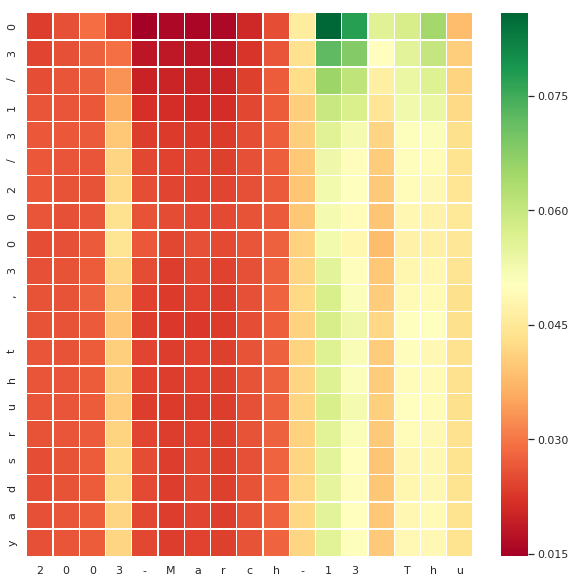

In [29]:
example = [gen_date() for _ in range(1)]
plot_attention(model, example)